In [1]:
"""
A simple version of Proximal Policy Optimization (PPO) using single thread.
Based on:
1. Emergence of Locomotion Behaviours in Rich Environments (Google Deepmind): [https://arxiv.org/abs/1707.02286]
2. Proximal Policy Optimization Algorithms (OpenAI): [https://arxiv.org/abs/1707.06347]
View more on my tutorial website: https://morvanzhou.github.io/tutorials
Dependencies:
tensorflow r1.2
gym 0.9.2
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import gymfc
import os
import numpy as np

import nest_asyncio
nest_asyncio.apply()

EP_MAX = 10
EP_LEN = 200
GAMMA = 0.8
A_LR = 0.01
C_LR = 0.02
BATCH = 32
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
S_DIM, A_DIM = 7, 4
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),   # KL penalty
    dict(name='clip', epsilon=0.2),                 # Clipped surrogate objective, find this is better
][1]        # choose the method for optimization


class PPO(object):

    def __init__(self):
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, S_DIM], 'state')

        # critic
        with tf.variable_scope('critic'):
            l1 = tf.layers.dense(self.tfs, 100, tf.nn.relu)
            self.v = tf.layers.dense(l1, 1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))
            self.ctrain_op = tf.train.AdamOptimizer(C_LR).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)       # choosing action
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
                ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
                surr = ratio * self.tfadv
            if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))
            else:   # clipping method, find this is better
                self.aloss = -tf.reduce_mean(tf.minimum(
                    surr,
                    tf.clip_by_value(ratio, 1.-METHOD['epsilon'], 1.+METHOD['epsilon'])*self.tfadv))

        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(A_LR).minimize(self.aloss)

        tf.summary.FileWriter("log/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def update(self, s, a, r):
        self.sess.run(self.update_oldpi_op)
        adv = self.sess.run(self.advantage, {self.tfs: s, self.tfdc_r: r})
        # adv = (adv - adv.mean())/(adv.std()+1e-6)     # sometimes helpful

        # update actor
        if METHOD['name'] == 'kl_pen':
            for _ in range(A_UPDATE_STEPS):
                _, kl = self.sess.run(
                    [self.atrain_op, self.kl_mean],
                    {self.tfs: s, self.tfa: a, self.tfadv: adv, self.tflam: METHOD['lam']})
                if kl > 4*METHOD['kl_target']:  # this in in google's paper
                    break
            if kl < METHOD['kl_target'] / 1.5:  # adaptive lambda, this is in OpenAI's paper
                METHOD['lam'] /= 2
            elif kl > METHOD['kl_target'] * 1.5:
                METHOD['lam'] *= 2
            METHOD['lam'] = np.clip(METHOD['lam'], 1e-4, 10)    # sometimes explode, this clipping is my solution
        else:   # clipping method, find this is better (OpenAI's paper)
            [self.sess.run(self.atrain_op, {self.tfs: s, self.tfa: a, self.tfadv: adv}) for _ in range(A_UPDATE_STEPS)]

        # update critic
        [self.sess.run(self.ctrain_op, {self.tfs: s, self.tfdc_r: r}) for _ in range(C_UPDATE_STEPS)]

    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            l1 = tf.layers.dense(self.tfs, 100, tf.nn.relu, trainable=trainable)
            mu = 2 * tf.layers.dense(l1, A_DIM, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(l1, A_DIM, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def choose_action(self, s):
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.tfs: s})[0]
        return np.clip(a, -2, 2)

    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.tfs: s})[0, 0]

current_dir = os.getcwd()
config_path = os.path.join(current_dir, "../configs/iris.config")
os.environ["GYMFC_CONFIG"] = config_path

env = gym.make('AttFC_GyroErr-MotorVel_M4_Con-v0').unwrapped
# env = gym.make('Pendulum-v0').unwrapped
ppo = PPO()
all_ep_r = []

actuals = []
desireds = []
for ep in range(EP_MAX):
    s = env.reset()
    buffer_s, buffer_a, buffer_r = [], [], []
    ep_r = 0
    for t in range(EP_LEN):    # in one episode
        env.render()
        actuals.append(env.omega_actual)
        desireds.append(env.omega_target)
        a = ppo.choose_action(s)
        print(a)
        s_, r, done, _ = env.step(a)
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append((r+8)/8)    # normalize reward, find to be useful
        s = s_
        ep_r += r

        # update ppo
        if (t+1) % BATCH == 0 or t == EP_LEN-1:
            v_s_ = ppo.get_v(s_)
            discounted_r = []
            for r in buffer_r[::-1]:
                v_s_ = r + GAMMA * v_s_
                discounted_r.append(v_s_)
            discounted_r.reverse()

            bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
            buffer_s, buffer_a, buffer_r = [], [], []
            ppo.update(bs, ba, br)
    if ep == 0: all_ep_r.append(ep_r)
    else: all_ep_r.append(all_ep_r[-1]*0.9 + ep_r*0.1)
    print(
        'Ep: %i' % ep,
        "|Ep_r: %i" % ep_r,
        ("|Lam: %.4f" % METHOD['lam']) if METHOD['name'] == 'kl_pen' else '',
    )

plt.plot(np.arange(len(all_ep_r)), all_ep_r)
plt.xlabel('Episode');plt.ylabel('Moving averaged episode reward');plt.show()

Starting gzserver with process ID= 12867
[-0.37780786  1.1256037   1.1327542  -0.3069385 ]
[-1.4607608  -0.30211854  1.2844131  -0.84560555]
[-1.9742523   2.         -0.10284345  2.        ]
[-2.         2.         1.900562   1.5924859]
[-1.9999804 -2.         1.7423389 -2.       ]
[-1.9999859  -2.         -0.24237423  2.        ]
[-1.9999969  -2.         -0.97670394  2.        ]
[-1.9999971 -2.         1.3322624  2.       ]
[-2.          2.          0.81564826  0.0758785 ]
[-2.        -2.         1.6660413  2.       ]
[-2.       -2.        1.470587  2.      ]
[-2.        -2.         1.3917959 -2.       ]
[-2.        -2.        -1.7956091 -2.       ]
[-2.        -2.        -1.7623211 -2.       ]
[-2.         1.1440922 -1.72193   -2.       ]
[-2.       -2.       -0.762131  2.      ]
[-2.         2.         1.2914559  2.       ]
[-2.         2.         1.7994694  2.       ]
[-2.        -2.         1.9635289  2.       ]
[-2.         2.         1.8954647  2.       ]
[-2.        -2.        

[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan n

[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan n

[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan n

[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
Ep: 8 |Ep_r: -79 
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan n

<Figure size 640x480 with 1 Axes>

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import math
%matplotlib inline
def plot_step_response(desired, actual,
                       end=1., title=None,
                       step_size=0.001, threshold_percent=0.1):
    """
        Args:
            threshold (float): Percent of the start error
    """

    # actual = actual[:,:end,:]
    end_time = len(desired) * step_size
    t = np.arange(0, end_time, step_size)

    # desired = desired[:end]
    threshold = threshold_percent * desired

    plot_min = -math.radians(350)
    plot_max = math.radians(350)

    subplot_index = 3
    num_subplots = 3

    f, ax = plt.subplots(num_subplots, sharex=True, sharey=False)
    f.set_size_inches(10, 5)
    if title:
        plt.suptitle(title)
    ax[0].set_xlim([0, end_time])
    res_linewidth = 2
    linestyles = ["c", "m", "b", "g"]
    reflinestyle = "k--"
    error_linestyle = "r--"

    # Always
    ax[0].set_ylabel("Roll (rad/s)")
    ax[1].set_ylabel("Pitch (rad/s)")
    ax[2].set_ylabel("Yaw (rad/s)")

    ax[-1].set_xlabel("Time (s)")

    """ ROLL """
    # Highlight the starting x axis
    ax[0].axhline(0, color="#AAAAAA")
    ax[0].plot(t, desired[:, 0], reflinestyle)
    ax[0].plot(t, desired[:, 0] - threshold[:, 0], error_linestyle, alpha=0.5)
    ax[0].plot(t, desired[:, 0] + threshold[:, 0], error_linestyle, alpha=0.5)

    r = actual[:, 0]
    ax[0].plot(t[:len(r)], r, linewidth=res_linewidth)

    ax[0].grid(True)

    """ PITCH """

    ax[1].axhline(0, color="#AAAAAA")
    ax[1].plot(t, desired[:, 1], reflinestyle)
    ax[1].plot(t, desired[:, 1] - threshold[:, 1], error_linestyle, alpha=0.5)
    ax[1].plot(t, desired[:, 1] + threshold[:, 1], error_linestyle, alpha=0.5)
    p = actual[:, 1]
    ax[1].plot(t[:len(p)], p, linewidth=res_linewidth)
    ax[1].grid(True)

    """ YAW """
    ax[2].axhline(0, color="#AAAAAA")
    ax[2].plot(t, desired[:, 2], reflinestyle)
    ax[2].plot(t, desired[:, 2] - threshold[:, 2], error_linestyle, alpha=0.5)
    ax[2].plot(t, desired[:, 2] + threshold[:, 2], error_linestyle, alpha=0.5)
    y = actual[:, 2]
    ax[2].plot(t[:len(y)], y, linewidth=res_linewidth)
    ax[2].grid(True)

    plt.savefig("gymfc-ppo-step-response.pdf")

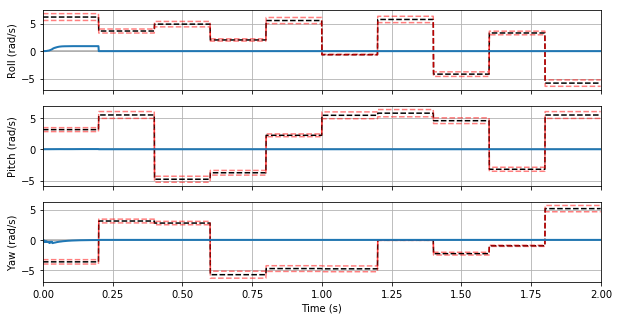

In [3]:
plot_step_response(np.array(desireds), np.array(actuals))